In [166]:
import pandas as pd
import numpy as np
import torch
import re
import string

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline

from sentence_transformers import SentenceTransformer
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
import nltk
from nltk.corpus import stopwords
import contractions

from config import OPENAI_API_KEY

# 2. Data Exploration

In [167]:
df = pd.read_csv('us_cancellation_feedback.csv')

df.head()

,Month of Action Date,Career,Score Reason,Additional Comment
0,Aug-24,parent,Resource Quality,Such fabulous resources. Just not using as des...
1,Aug-24,ey,Price,I was charged $9 for monthly renewal on 8/10. ...
2,Aug-24,ks3,Price,most of the resources I found were more for el...
3,Aug-24,US Grade 1,Price,It made me laugh that the bot couldn't underst...
4,Aug-24,US Grade 5,Price,I will be back! Our school had to cut our clas...


In [168]:
df.columns

Index(['Month of Action Date', 'Career', 'Score Reason', 'Additional Comment'], dtype='object')

In [169]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

df.columns

Index(['month_of_action_date', 'career', 'score_reason', 'additional_comment'], dtype='object')

<Axes: xlabel='count', ylabel='score_reason'>

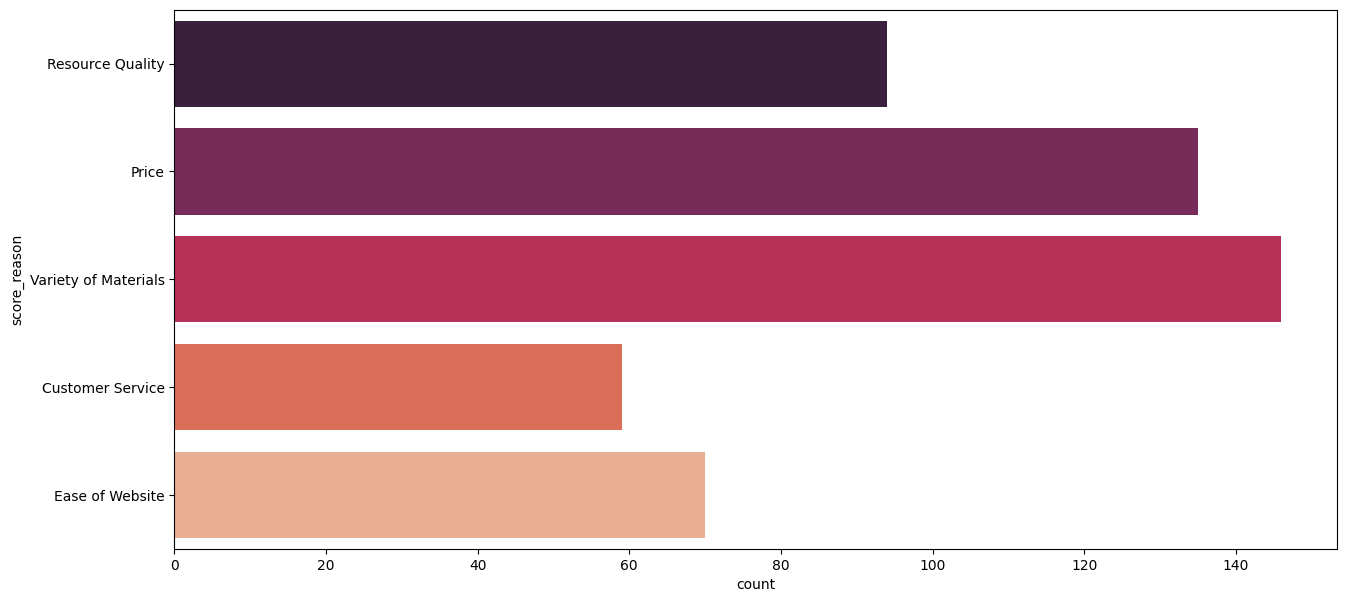

In [170]:
plt.figure(figsize=(15,7))
sns.countplot(y='score_reason', data=df, hue='score_reason', palette='rocket', legend=False)

<Axes: xlabel='count', ylabel='career'>

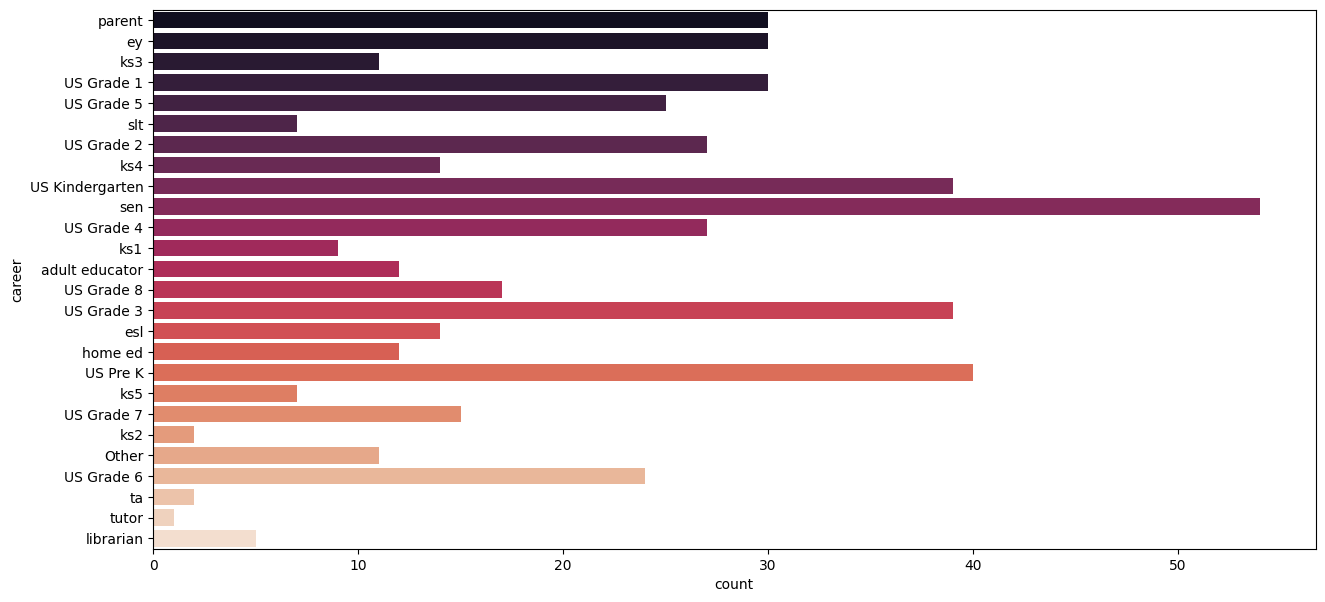

In [171]:
plt.figure(figsize=(15,7))
sns.countplot(y='career', data=df, hue='career', palette='rocket', legend=False)

In [172]:
df.isna().sum()

month_of_action_date    0
career                  0
score_reason            0
additional_comment      0
dtype: int64

In [173]:
df.dtypes

month_of_action_date    object
career                  object
score_reason            object
additional_comment      object
dtype: object

# 2. Data Cleaning

## 2.1 Cleaning Text

# 2.2. Format Dates

In [174]:
clean_df = df.copy()

clean_df['month_of_action_date'] = pd.to_datetime(clean_df['month_of_action_date'], format='%b-%y')

print(clean_df.dtypes)
clean_df.head()

month_of_action_date    datetime64[ns]
career                          object
score_reason                    object
additional_comment              object
dtype: object


,month_of_action_date,career,score_reason,additional_comment
0,2024-08-01,parent,Resource Quality,Such fabulous resources. Just not using as des...
1,2024-08-01,ey,Price,I was charged $9 for monthly renewal on 8/10. ...
2,2024-08-01,ks3,Price,most of the resources I found were more for el...
3,2024-08-01,US Grade 1,Price,It made me laugh that the bot couldn't underst...
4,2024-08-01,US Grade 5,Price,I will be back! Our school had to cut our clas...


In [175]:
import langid 
import openai


OPENAI_API_KEY = OPENAI_API_KEY

SKIP_TRANSLATION = False



def detect_language(text):
    try:
        lang, _ = langid.classify(text)
        return 'en' if lang == 'en' else 'non-en'
    except:
        return "unknown"

## -- TRANSLATE TEXT

def translate_text(text):
    if SKIP_TRANSLATION:
        return text  # Skip translation and return the original text

    openai.api_key = OPENAI_API_KEY  # Make sure to replace this with your actual API key

    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are an expert multilingual translator working at a subscription-based EDU publishing company."},
            {"role": "user", "content": f"""
Below you will find a survey response from our Exit Survey that is not in English.
Your goal is to read it carefully in order to identify the original language of the response, and then translate it into English
being as true to the original intent as possible. \n

## RULES: \n

1. Your output should ONLY contain the translated text. Do NOT, under any circumstance, include any additional text, information, or explanations.
2. Do NOT under any circumstance wrap your answer around quotation marks.
3. If the text seems to be in English or you can't identify the language, or the text appears to be gibberish, simply return the same exact text you received for translation in accordance with rules 1 and 2.

\n

## TEXT FOR TRANSLATION BELOW (all text after this line only for translation purposes): \n

{text}

"""}],
        temperature=0.5
    )
    print(response.choices[0].message.content)
    return response.choices[0].message.content


In [176]:
clean_df['language'] = clean_df['additional_comment'].apply(detect_language)

In [177]:
for index, row in clean_df.iterrows():
    if row['language'] != 'en':  # Check if language is not English
        clean_df.at[index, 'additional_comment'] = translate_text(row['additional_comment'])  # Translate and replace text

I thought months ago that I had stopped paying for this subscription and that I had canceled it, but it turns out I haven't.
I loved the resources and used them a lot with my students. It's just that the price is high for me and I can't afford it. Thank you for creating such good material.
I really liked the subscription but financing is difficult now. Maybe I will respond to it in the future.


In [178]:
clean_df[clean_df['language'] != 'en']

,month_of_action_date,career,score_reason,additional_comment,language
46,2024-08-01,US Kindergarten,Price,I thought months ago that I had stopped paying...,non-en
329,2024-11-01,sen,Price,I loved the resources and used them a lot with...,non-en
494,2025-01-01,ks3,Ease of Website,I really liked the subscription but financing ...,non-en


In [179]:
def simple_text_preprocessing(df, source_column, target_column):

    def clean_text(text):
        text = text.strip().lower()
        text = re.sub(r'<[^>]+>', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(text.split())

    df = df.copy()
    df[source_column] = df[source_column].fillna("").astype(str)
    df[target_column] = df[source_column].apply(clean_text)
    df[target_column] = df[target_column].replace("", pd.NA)
    return df.dropna(subset=[target_column]).reset_index(drop=True)

In [180]:
cleaned_text_df = clean_df.copy()

cleaned_text_df = simple_text_preprocessing(cleaned_text_df, 'additional_comment', 'cleaned_text')

cleaned_text_df.head()

,month_of_action_date,career,score_reason,additional_comment,language,cleaned_text
0,2024-08-01,parent,Resource Quality,Such fabulous resources. Just not using as des...,en,such fabulous resources just not using as desi...
1,2024-08-01,ey,Price,I was charged $9 for monthly renewal on 8/10. ...,en,i was charged 9 for monthly renewal on 810 the...
2,2024-08-01,ks3,Price,most of the resources I found were more for el...,en,most of the resources i found were more for el...
3,2024-08-01,US Grade 1,Price,It made me laugh that the bot couldn't underst...,en,it made me laugh that the bot couldnt understa...
4,2024-08-01,US Grade 5,Price,I will be back! Our school had to cut our clas...,en,i will be back our school had to cut our class...


In [181]:
cleaned_text_df = cleaned_text_df.drop(cleaned_text_df.columns[4], axis=1)
cleaned_text_df.columns

Index(['month_of_action_date', 'career', 'score_reason', 'additional_comment',
       'cleaned_text'],
      dtype='object')

In [182]:
cleaned_text_df.to_csv('cleaned_data.csv', index=False)

# 3. Data Analysis

## 3.1 Sentiment Analysis

In [183]:
from textblob import TextBlob

def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def label_sentiment(score, threshold=0.2):
    if score > threshold:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [184]:
cleaned_text_df['sentiment_score'] = cleaned_text_df['additional_comment'].apply(analyze_sentiment)

cleaned_text_df['sentiment'] = cleaned_text_df['sentiment_score'].apply(label_sentiment)

In [185]:
cleaned_text_df.head()

,month_of_action_date,career,score_reason,additional_comment,cleaned_text,sentiment_score,sentiment
0,2024-08-01,parent,Resource Quality,Such fabulous resources. Just not using as des...,such fabulous resources just not using as desi...,0.260000,Positive
1,2024-08-01,ey,Price,I was charged $9 for monthly renewal on 8/10. ...,i was charged 9 for monthly renewal on 810 the...,0.000000,Neutral
2,2024-08-01,ks3,Price,most of the resources I found were more for el...,most of the resources i found were more for el...,0.078472,Neutral
3,2024-08-01,US Grade 1,Price,It made me laugh that the bot couldn't underst...,it made me laugh that the bot couldnt understa...,0.306250,Positive
4,2024-08-01,US Grade 5,Price,I will be back! Our school had to cut our clas...,i will be back our school had to cut our class...,0.133333,Neutral


In [186]:
sentiment_pie = px.pie(
    cleaned_text_df, 
    names='sentiment',
    color='sentiment',
    color_discrete_map={'Positive':'darkturquoise', 'Neutral':'#646DEF', 'Negative':'red'},
    hole=0.45,
    title="Exit Sentiment Distribution"
)

sentiment_pie.update_traces(hovertemplate='%{label}<extra></extra>')

sentiment_pie.update_layout(
    width=450,
    height=650,
    title_font=dict(size=24),
    margin=dict(t=100, b=50, l=50, r=50),
    legend=dict(
                orientation="h",  # Horizontal legend
                yanchor="bottom",  # Ali
    )
)
sentiment_pie.show()

In [187]:
groupedby_career_sentiment = cleaned_text_df.groupby(['career', 'sentiment']).size().reset_index(name='count')

In [188]:
stacked_sentiment = px.bar(
    groupedby_career_sentiment,
    x="career",
    y= 'count',
    color="sentiment",
    color_discrete_map={'Positive':'darkturquoise', 'Neutral':'#646DEF', 'Negative':'red'},
    title="Career Responses Stacked by Sentiment",
    barmode="stack")

stacked_sentiment.update_layout(
    height=650,
    )

# Show the chart
stacked_sentiment.show()

## 3.2 Topic Modeling (Content)

In [189]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy
import re
import contractions

def topicModeling_preprocessing(df, source_column, target_column, spacy_model="en_core_web_lg"):

    base_stopwords = set(ENGLISH_STOP_WORDS) 

    custom_stopwords = {
        'material', 'materials', 'resources', 'resource', 'activity',
        'activities', 'sheet', 'sheets', 'worksheet', 'worksheets',
        'teacher', 'teachers', 'teach','use','twinkl', 'student', 'students',
        'lesson','lessons','homeschooling','homeschool', 'child', 'children', 'grade', 'grades', "1st", "2nd", "3rd", "4th", "5th", '6th',
        '7th', '8th', '9th','10th','11th','12th', 'kids', 'kid', 'language','membership', 'teaching', 'classroom', 'class', 'click', 'subscription', 'preschool', 'pre school',
        'geared', 'appropriate' 'gear','curriculum','upper', 'age', 'childhood', 'young', 'thing'
    }

    stopword_set = base_stopwords.union(custom_stopwords)
    stopword_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in stopword_set) + r')\b'

    nlp = spacy.load(spacy_model)

    def clean_lemmatize_text(text):
        if not isinstance(text, str):
            return None
        
        text = contractions.fix(text)
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(stopword_pattern, '', text)

        doc = nlp(text)

        tokens = [token.text if token.text.lower() == "planner" else token.lemma_ for token in doc]
        
        clean_text = " ".join(tokens).strip()
        clean_text = re.sub(r'\s+', ' ', clean_text)

        return clean_text if clean_text else None

    df[target_column] = df[source_column].apply(clean_lemmatize_text)

    # Drop rows where cleaned text is empty or None
    df = df.dropna(subset=[target_column])

    return df

Now we explore the responses for only content-related issues. Those being in the "Resource Quality" and "variety of Materials" categories

In [190]:
cleaned_text_df = cleaned_text_df.copy()

cleaned_text_df = topicModeling_preprocessing(cleaned_text_df, 'cleaned_text', 'preprocessed')

In [191]:
content_responses_df = cleaned_text_df[(cleaned_text_df['score_reason']=="Resource Quality") |
(cleaned_text_df['score_reason']=="Variety of Materials")]

len(content_responses_df)

240

In [268]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.representation import MaximalMarginalRelevance

def load_embedding_model():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"

    return SentenceTransformer("sentence-t5-large", device=device)

def encode_content_documents(embedding_model, content_documents, batch_size=20):
    embeddings_batches = []

    for i in range(0, len(content_documents), batch_size):
        batch_docs = content_documents[i:i + batch_size]
        batch_embeddings = embedding_model.encode(batch_docs, convert_to_numpy=True, show_progress_bar=True)
        embeddings_batches.append(batch_embeddings)

    return np.vstack(embeddings_batches)



def fit_bertopic_content(_embedding_model, content_documents, embeddings):

    base_stopwords = set(ENGLISH_STOP_WORDS) 

    custom_stopwords = {
        'material', 'materials', 'resources', 'resource', 'activity',
        'activities', 'sheet', 'sheets', 'worksheet', 'worksheets',
        'teacher', 'teachers', 'teach','use','twinkl', 'student', 'students',
        'lesson','lessons','homeschooling','homeschool', 'child', 'children', 'grade', 'grades', "1st", "2nd", "3rd", "4th", "5th", '6th',
        '7th', '8th', '9th','10th','11th','12th', 'kids', 'kid', 'language','membership', 'teaching', 'classroom', 'class', 'click', 'subscription', 'preschool', 'pre school',
        'geared', 'appropriate' 'gear','curriculum','upper', 'age', 'childhood', 'young', 'thing', 'unfortunately', 'currently','presentation',
        'presentations','ppt','powerpoint','visuals','visual', 'shool program','high school', 'highschool', 'middle school', 'summer school', 'summer'
        'elementary', 'hs', 'high', 'workbook', 'workbooks', 'nice', 'great', 'stellar','program', 'year', 'topic', 'related'
    }

    stopword_set = base_stopwords.union(custom_stopwords)


    
    vectorizer_model = TfidfVectorizer(ngram_range=(1,3), stop_words=list(stopword_set))

    
    topic_model=BERTopic(
        embedding_model=_embedding_model,
        language='english',
        representation_model=KeyBERTInspired(),
        calculate_probabilities=True,
        vectorizer_model=vectorizer_model,
        min_topic_size=3,
        top_n_words=4,
    )
   
    topics, probs = topic_model.fit_transform(content_documents, embeddings)

    return topic_model, topics, probs



In [262]:
embedding_model = load_embedding_model()

In [263]:
content_documents = content_responses_df['preprocessed'].dropna().tolist()

In [264]:
embeddings = encode_content_documents(embedding_model, content_documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [269]:
topic_model, topics, probs = fit_bertopic_content(embedding_model, content_documents, embeddings)

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,51,-1_math_math standard_68 math_business math un...,"[math, math standard, 68 math, business math u...",[sel crap really think people understand horri...
1,0,42,0_plan month cancel_cancel month_try cancel mo...,"[plan month cancel, cancel month, try cancel m...",[try cancel month continue charge use like ref...
2,1,27,1_caregiver join adapt_new job_job_support aut...,"[caregiver join adapt, new job, job, support a...",[plan continue future fulfill year money maint...
3,2,19,2_print download zip_print download_download z...,"[print download zip, print download, download ...",[go try educationcom okay hate blue ink waste ...
4,3,13,3_print want_printable feel like_printable_sub...,"[print want, printable feel like, printable, s...",[wish interactive just powerpoint print requir...
5,4,11,4_school service middle_school vocational litt...,"[school service middle, school vocational litt...",[move middle school math high school math look...
6,5,10,5_look english phonic_look vocabulary grammar_...,"[look english phonic, look vocabulary grammar,...",[look english phonic game plus interesting eng...
7,6,8,6_expensive consider subscribe_justify monthly...,"[expensive consider subscribe, justify monthly...",[feel like price significantly increase year g...
8,7,8,7_parish provide bible_christian content_provi...,"[parish provide bible, christian content, prov...",[look various subject math science english flo...
9,8,8,8_modify greatly make_advanced design_modify g...,"[modify greatly make, advanced design, modify ...","[strictly look newcomer el advanced design el,..."


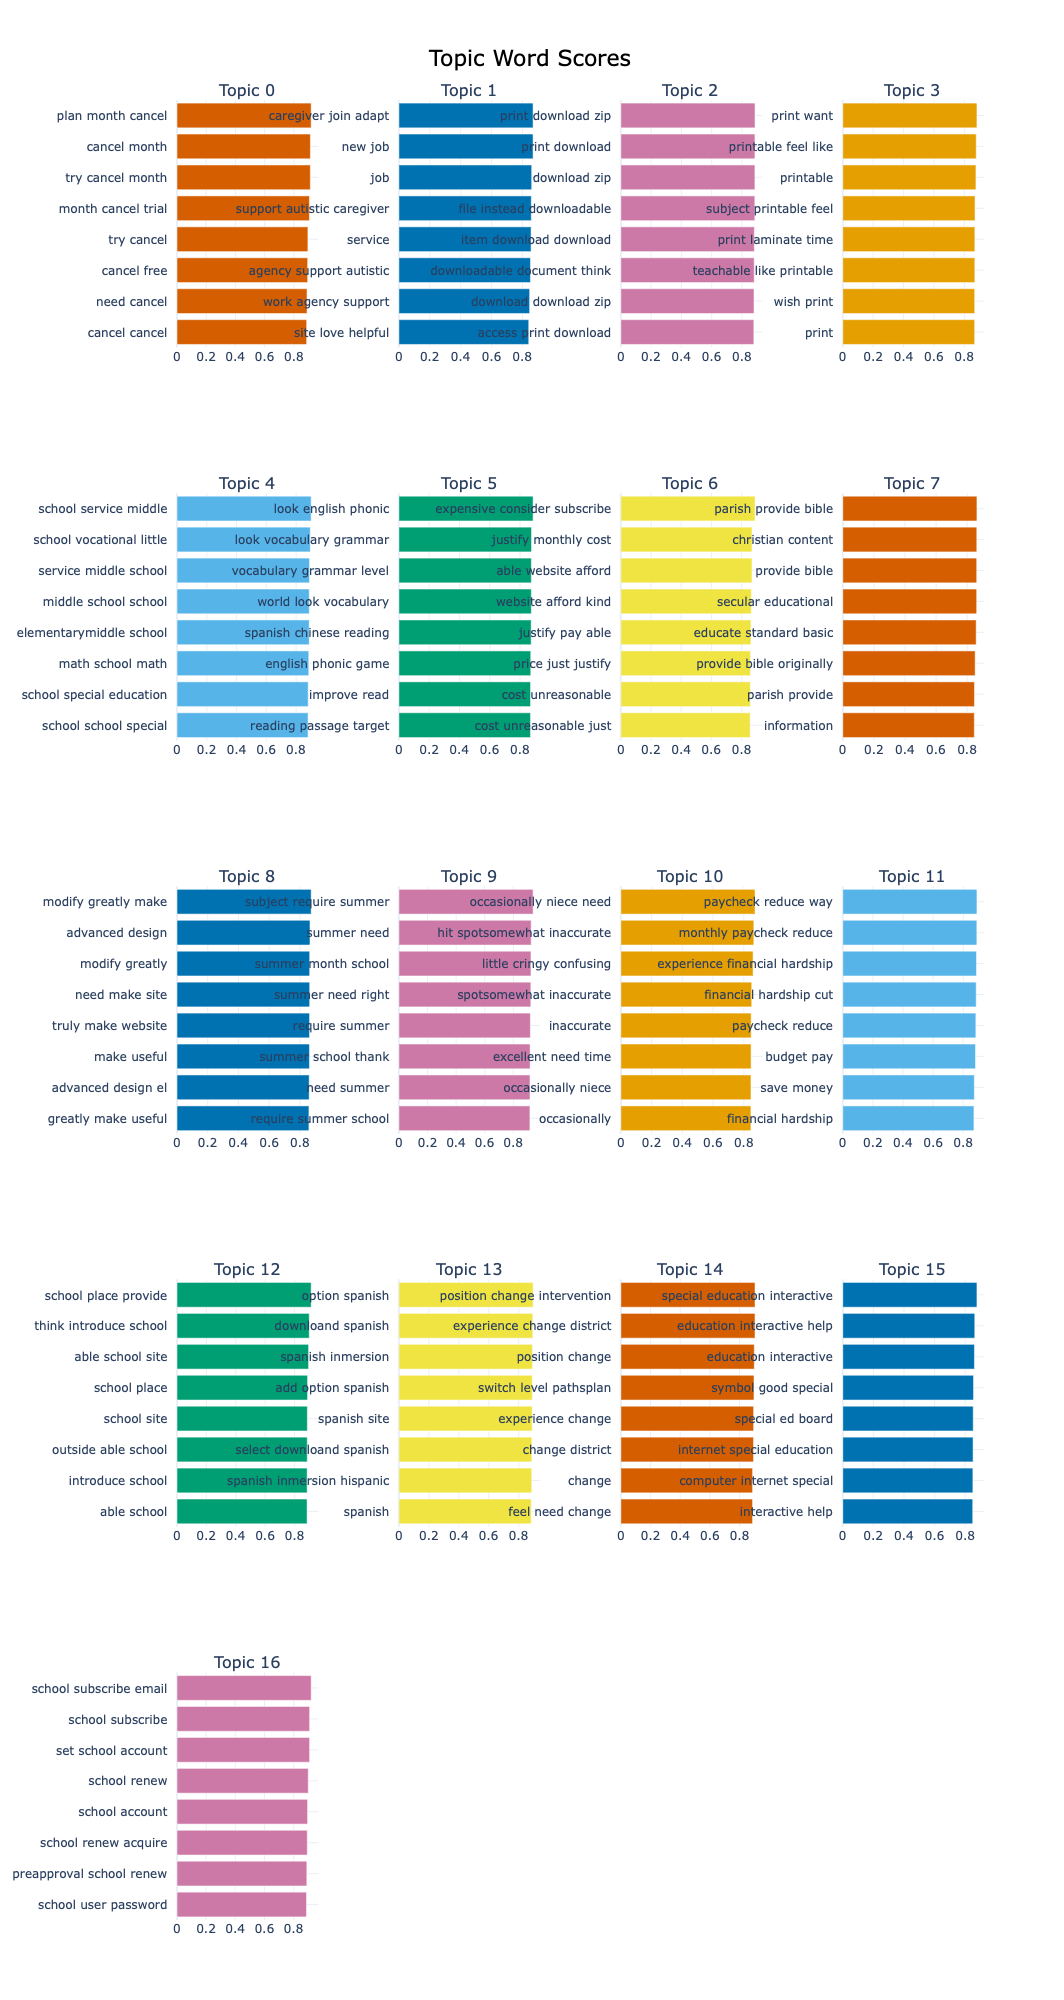

In [271]:
topic_model.visualize_barchart(
    top_n_topics=20,
    n_words=8,
    autoscale=False,
    width=250,
    height=400
)

In [272]:
timestamps = content_responses_df['month_of_action_date'].to_list()
topics_over_time = topic_model.topics_over_time(content_documents, timestamps, nr_bins=20)
topics_over_time.to_csv("topics_over_time.csv", index=False)

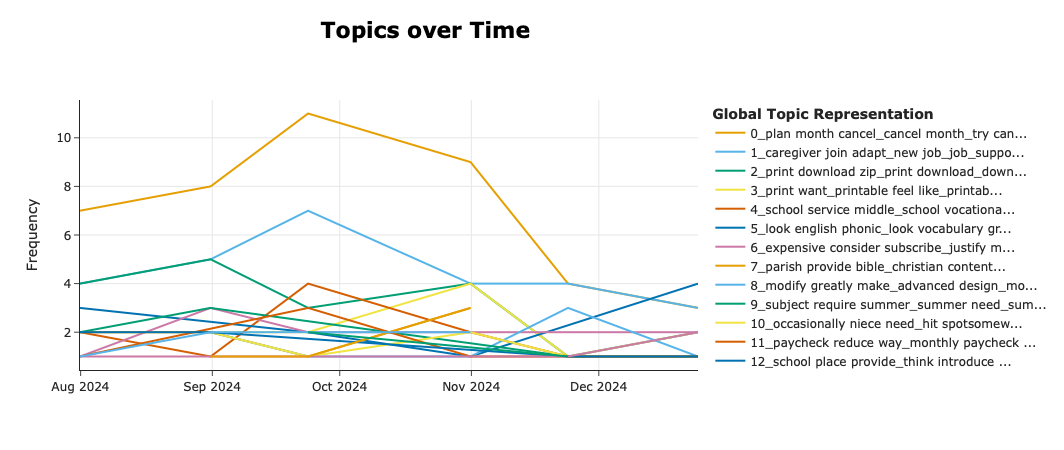

In [273]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

100%|██████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.84it/s]


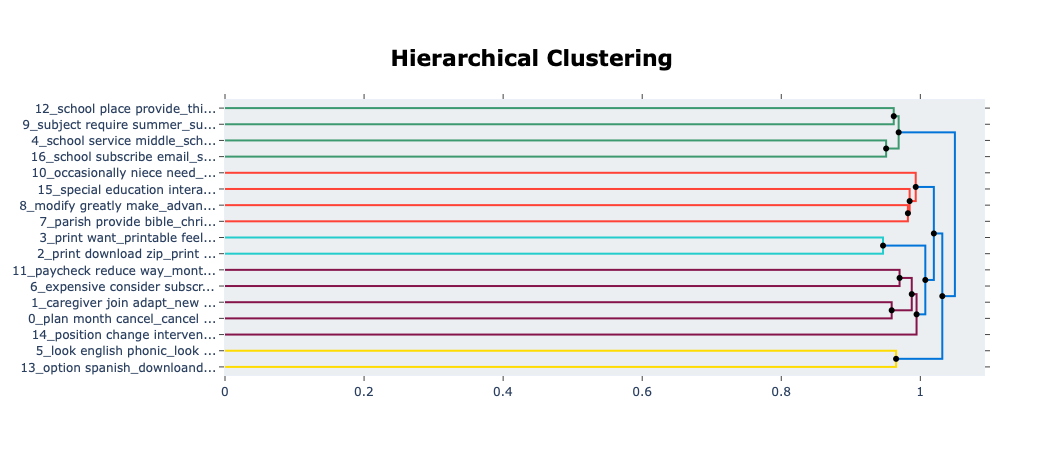

In [283]:
# Extract hierarchical topics and their representations
hierarchical_topics = topic_model.hierarchical_topics(content_documents)

# Visualize these representations
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, height=350)


In [278]:
new_topics = topic_model.reduce_outliers(content_documents, topics)

In [679]:
import pandas as pd

# Get topic information
topic_info = topic_model.get_topic_info()

# Save to CSV
topic_info.to_csv("bertopic_topics.csv", index=False)

In [282]:
# Save the model
topic_model.save("bertopic_model")

# Load the model later
from bertopic import BERTopic
loaded_model = BERTopic.load("bertopic_model")

2025-02-05 20:16:15,046 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
content_responses_df['topic'] = topics

# Display updated DataFrame
import pandas as pd
display(content_responses_df[['preprocessed', 'additional_comment', 'topic']].head())

In [ ]:
# Get topic names (Top words per topic)
topic_info = topic_model.get_topic_info()[['Topic', 'Name']].set_index('Topic')

# Merge topic labels with the original DataFrame
content_responses_df['topic_label'] = content_responses_df['topic'].map(topic_info['Name'])

# Display results
display(content_responses_df[['additional_comment', 'topic', 'topic_label']].head())